# [IAPR][iapr]: Lab 2 ‒  Object description


**Group ID:** xx

**Author 1 (sciper):** Basile Spaenlehauer (272570)

**Author 2 (sciper):** Victor Herrmann (284552)

**Author 3 (sciper):** Abed Alrahman Shabaan (237731)

**Release date:** 26.03.2021  
**Due date:** 23.04.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. Showing invariance to rotation, translation and scaling (5 pts).
2. Additional method of your choice (5 pts)


**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

### 1.1 Data visualization

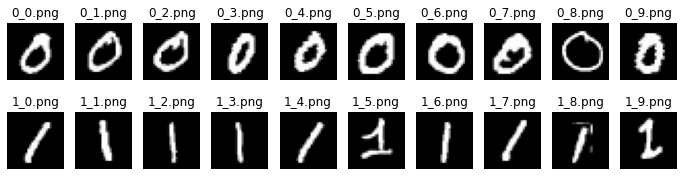

In [97]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')


# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

Let's see the contours

In [144]:
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import binary_opening
from skimage.feature import canny
from scipy.signal import resample

We start by applying a morphological opening to remove the small artefacts in our images.

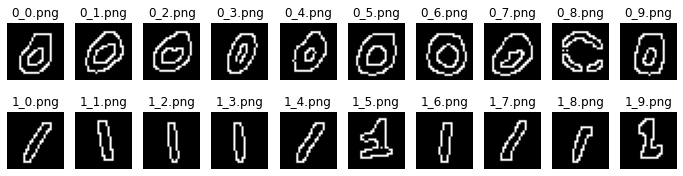

In [101]:
zeros_im_closed = np.array([binary_opening(zero, selem=skimage.morphology.selem.disk(1)) for zero in zeros_im])
ones_im_closed = np.array([binary_opening(one, selem=skimage.morphology.selem.disk(1)) for one in ones_im])

fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im_closed, zeros_names):
    ax.imshow(canny(im), cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im_closed, ones_names):
    ax.imshow(canny(im), cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

plt.show()


### 1.2 Fourier descriptors (15 pts)

In [158]:
def fourrier_discs(im_list, level=0.5, nb_points = 200):
# Add your implementation and discussion

    edges = [find_contours(image, level=level)for image in im_list]

    contours = np.empty((im_list.shape[0], nb_points, 2))

    for i,contour_set in enumerate(edges): # contour_set will be a list of all the separate contours
        nb_conts = len(contour_set)
        for contour in contour_set:
            contours[i] = resample(contour, nb_points//nb_conts)

    # Concatenate multiple contours of each number
    contours = [np.concatenate(x, axis=0) for x in contours]

    edges_cpx = []

    for i in range(len(contours)):
        edges_cpx.append(contours[i][:,0] + 1j*contours[i][:,1])


    fourier = [np.abs(np.fft.fft(edge)) for edge in edges_cpx]
    return fourier

After having calculated the Fourier descriptors, we can now proceed to plot the first two components.

In [128]:
def plot_fourier_disc(zero_fourier_disc, one_fourier_disc):

    x_0 = [zero_fourier_disc[i][1]/zero_fourier_disc[i][0] for i in range (len(zero_fourier_disc))]
    y_0 = [zero_fourier_disc[i][2]/zero_fourier_disc[i][0] for i in range (len(zero_fourier_disc))]

    x_1 = [one_fourier_disc[i][1]/zero_fourier_disc[i][0] for i in range (len(one_fourier_disc))]
    y_1 = [one_fourier_disc[i][2]/zero_fourier_disc[i][0] for i in range (len(one_fourier_disc))]

    plt.scatter(x_0, y_0, label='0')
    plt.scatter(x_1, y_1, label='1')

    plt.legend()
    plt.title('First two normalized components of the fourier descriptors')
    plt.xlabel('f1/f0')
    plt.ylabel('f2/f0')


In [159]:
zeros_fourier = fourrier_discs(zeros_im)
ones_fourier = fourrier_discs(ones_im)
plot_fourier_disc(zeros_fourier, ones_fourier)

ValueError: could not broadcast input array from shape (100,2) into shape (200,2)

We can see that the two numbers are linearly separable in this space, and so we can classify them using a simple logistic regression.

We rotate the images and check if the transform is rotation invariant, it should be the case since we only consider the amplitude of the Fourier descriptors

In [140]:
from skimage.transform import  rotate, rescale

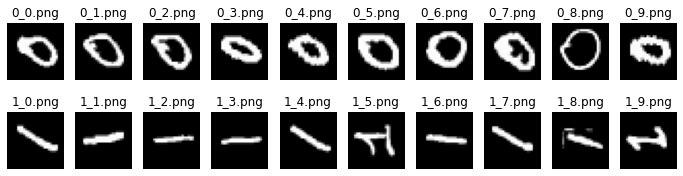

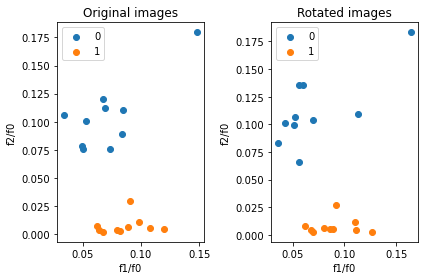

In [143]:
zeros_rotated = np.array([rotate(zero, angle=90, preserve_range=True).astype(np.uint8) for zero in zeros_im])
ones_rotated = np.array([rotate(one, angle=90, preserve_range=True).astype(np.uint8) for one in ones_im])

#zeros_rotated = np.array([zero.T[::-1,:] for zero in zeros_im])
#ones_rotated = np.array([one.T[::-1,:] for one in ones_im])

fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_rotated, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_rotated, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

plt.show()

plt.subplot(121)
plot_fourier_disc(zeros_fourier, ones_fourier)
plt.title('Original images')
plt.subplot(122)
zeros_rotated_fourier = fourrier_discs(zeros_rotated)
ones_rotated_fourier = fourrier_discs(ones_rotated)
plot_fourier_disc(zeros_rotated_fourier, ones_rotated_fourier)
plt.title('Rotated images')
plt.tight_layout()
plt.show()


Well, that was a disaster, let's try scaling.

In [142]:
zeros_scaled = np.array([rescale(zero, scale=0.5, preserve_range=True).astype(np.uint8) for zero in zeros_im])
ones_scaled = np.array([rescale(one, scale=0.5, preserve_range=True).astype(np.uint8) for one in ones_im])

zeros_scaled = zeros_im[:,::2,::2]
ones_scaled = ones_im


fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_scaled, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_scaled, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

plt.show()

plt.subplot(121)
plot_fourier_disc(zeros_fourier, ones_fourier)
plt.title('Original images')
plt.subplot(122)
zeros_scaled_fourier = fourrier_discs(zeros_scaled)
ones_scaled_fourier = fourrier_discs(ones_scaled)
plot_fourier_disc(zeros_scaled_fourier, ones_scaled_fourier)
plt.title('Rotated images')
plt.tight_layout()
plt.show()

TypeError: resize() got an unexpected keyword argument 'scale'

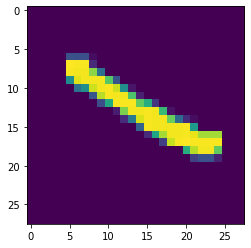

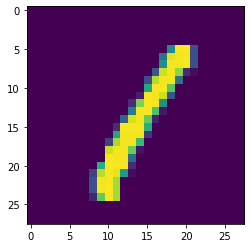

In [137]:
plt.imshow(ones_im[0].T[::-1,:])
plt.figure()
plt.imshow(ones_im[0])
plt.show()

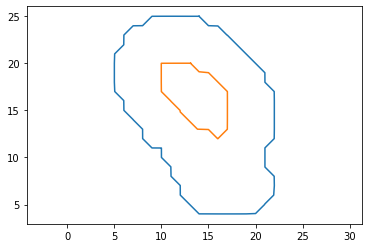

In [66]:
res = (find_contours(zeros_im[0], level=0.5))
for x in res:
    plt.plot(x[:,1],x[:,0])
plt.axis('equal')
plt.show()

In [44]:
res[0]

array([[11.2, 20. ],
       [11. , 19.8],
       [10. , 19.8],
       [ 9. , 19.8],
       [ 8. , 19.8],
       [ 7. , 19.8],
       [ 6.2, 19. ],
       [ 6. , 18.8],
       [ 5.2, 18. ],
       [ 5.2, 17. ],
       [ 5.2, 16. ],
       [ 5.2, 15. ],
       [ 6. , 14.2],
       [ 6.2, 14. ],
       [ 7. , 13.2],
       [ 7.2, 13. ],
       [ 7. , 12.8],
       [ 6. , 12.8],
       [ 5.8, 13. ],
       [ 5. , 13.8],
       [ 4.8, 14. ],
       [ 4.8, 15. ],
       [ 4.8, 16. ],
       [ 4.8, 17. ],
       [ 4.8, 18. ],
       [ 4.8, 19. ],
       [ 5. , 19.2],
       [ 5.8, 20. ],
       [ 6. , 20.2],
       [ 7. , 20.2],
       [ 8. , 20.2],
       [ 9. , 20.2],
       [10. , 20.2],
       [11. , 20.2],
       [11.2, 20. ]])

### 1.3 Additional method (5 pts)

We compare our input image to a circle and a straight line, and choose the distance between the image and each of those as features.

To do so, we calculate a distance map for the circle and the line images.

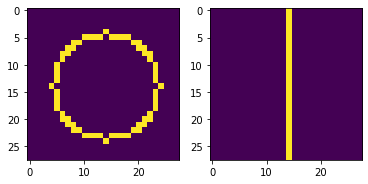

In [188]:
# Add your implementation and discussion
circle = np.pad(skimage.morphology.selem.disk(10), (4,4), constant_values=0)[:-1,:-1] - np.pad(skimage.morphology.selem.disk(9), pad_width=(5,5), constant_values=0)[:-1,:-1]
line = np.zeros((28,28))
line[:,14] = 1
plt.subplot(121)
plt.imshow(circle)
plt.subplot(122)
plt.imshow(line)
plt.show()

Next we calculate the distance maps for each of these elements.

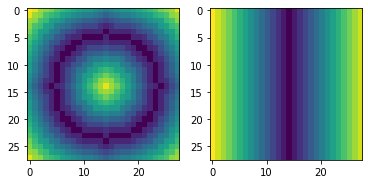

In [213]:
circle_map = circle.copy()
circle_map[circle==0] = 255
circle_map[circle==255] = 0
line_map = line.copy()
line_map[line==0] = 255
line_map[line==255] = 0

line_map = np.pad(line_map, pad_width=1, constant_values=255)
circle_map = np.pad(circle_map, pad_width=1, constant_values=255)

# Forward pass
for i in range(1,circle_map.shape[0]):
    for j in range(1,circle_map.shape[1]-1):
        circle_map[i,j] = min([circle_map[i,j], 3+circle_map[i-1,j], 3+circle_map[i, j-1], 4+circle_map[i-1,j-1], 4+circle_map[i-1,j+1]])
        line_map[i,j] = min([line_map[i,j], 3+line_map[i-1,j], 3+line_map[i, j-1], 4+line_map[i-1,j-1], 4+line_map[i-1,j+1]])

# Back pass
for i in range(circle_map.shape[0]-2,-1,-1):
    for j in range(circle_map.shape[1]-2,0,-1):
        circle_map[i,j] = min([circle_map[i,j], 3+circle_map[i+1,j], 3+circle_map[i, j+1], 4+circle_map[i+1,j-1], 4+circle_map[i+1,j+1]])
        line_map[i,j] = min([line_map[i,j], 3+line_map[i+1,j], 3+line_map[i, j+1], 4+line_map[i+1,j-1], 4+line_map[i+1,j+1]])

circle_map = circle_map[1:-1, 1:-1]
line_map = line_map[1:-1, 1:-1]
plt.subplot(121)
plt.imshow(circle_map)
plt.subplot(122)
plt.imshow(line_map)
plt.show()

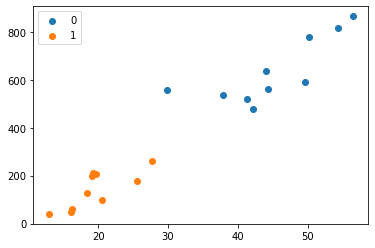

In [225]:
dist_zeros_circle = (zeros_im * circle_map).mean(axis=(1,2))
dist_zeros_bar = (zeros_im * line_map).mean(axis=(1,2))

dist_ones_circle = (ones_im * circle_map).mean(axis=(1,2))
dist_ones_bar = (ones_im * line_map).mean(axis=(1,2))

dist_zeros = np.concatenate([dist_zeros_circle.reshape(-1,1), dist_zeros_bar.reshape(-1,1)], axis=1)
dist_ones = np.concatenate([dist_ones_circle.reshape(-1,1), dist_ones_bar.reshape(-1,1)], axis=1)

plt.scatter(dist_zeros[:,0], dist_zeros[:,1], label='0')
plt.scatter(dist_ones[:,0], dist_ones[:,1], label='1')

plt.legend()
plt.show()

In [224]:
dist_ones.shape

(10, 2)

---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

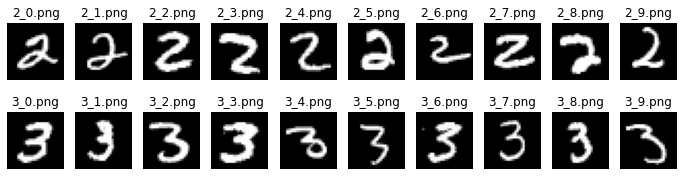

In [226]:
#  Load twos and threes
twos_im, twos_names = load(data_part2, digit='2')
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptors - 4 digits (10 pts)

In [ ]:
# Add your implementation and discussion
